In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import random as rd
import time
from IPython import display
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from scipy.special import factorial
import scipy as sp
import sys
import os
user_ops_path = '/usr/local/lib/python2.7/dist-packages/tensorflow/core/user_ops/'
sys.path.insert(0, user_ops_path)
import matexp_grad
matrix_exp_module = tf.load_op_library(os.path.join(user_ops_path,'cuda_matexp.so'))
from qutip import *
from tensorflow.python.ops import control_flow_ops
#matrix_exp_module = tf.load_op_library(os.path.join(user_ops_path,'matrix_exp.so'))

Populating the interactive namespace from numpy and matplotlib


### Complex to Real Isomorphism

In [2]:
def CtoRMat(M):
    return np.asarray(np.bmat([[M.real,-M.imag],[M.imag,M.real]]))

In [3]:
def Get_State_indices(bareindex,modenum,eigenvectors):
    qubit= int(bareindex/modenum**2)
    mode1= int(bareindex-(qubit*modenum**2))/(modenum)
    mode2= bareindex % modenum
    return [qubit,mode1,mode2]

In [4]:
def Get_State_index(bareindex,dressed):
    return dressed.index(bareindex)

In [5]:
def Sort_ev(v,dressed):
    v_sorted=[]
    for ii in range (len(dressed)):
        v_sorted.append(np.transpose(v[:,Get_State_index(ii,dressed)]))
    return np.transpose(v_sorted)

### Initialize System Parameters

In [6]:
'''
qubit_pi
two_modes_cnot
'''
#Setting Modulation to false will ignore the y pulse, it's as if we are only controlling x (by two equal signals) and z
simulation_system = "qubit_pi"
Modulation = True
Interpolation = True


In [7]:
class SystemParametersGeneral:

    def __init__(self,total_time):
        # Input variable
        self.total_time = total_time
        
        self.init_system()
        self.init_operators()
        self.init_one_minus_gaussian_envelop()
        self.init_pulse_operator()
        self.prev_ops_weight()
        self.Bessel_func()

    def init_system(self):
        self.initial_pulse = False
        self.prev_pulse = False

        self.qubit_state_num = 4
        self.alpha = 0.224574
        self.freq_ge = 3.9225#GHz
        self.ens = np.array([ 2*np.pi*ii*(self.freq_ge - 0.5*(ii-1)*self.alpha) for ii in arange(self.qubit_state_num)])

        self.mode_state_num = 3

        self.qm_g1 = 2*np.pi*0.1 #GHz
        self.mode_freq1 = 6.0 #GHz
        self.mode_ens1 = np.array([ 2*np.pi*ii*(self.mode_freq1) for ii in np.arange(self.mode_state_num)])


        self.qm_g2 = 2*np.pi*0.1 #GHz
        self.mode_freq2 = 6.5 #GHz
        self.mode_ens2 = np.array([ 2*np.pi*ii*(self.mode_freq2) for ii in np.arange(self.mode_state_num)])
        self.state_num = self.qubit_state_num * (self.mode_state_num**2)
        
        self.pts_per_period = 10
        self.exp_terms = 20
        self.subpixels = 50
        
        

        self.dt = (1./self.mode_freq1)/self.pts_per_period
        if Interpolation:
            self.Dt = self.dt*self.subpixels
        else:
            self.Dt = self.dt
        self.steps = int(self.total_time/self.dt) +1
        self.control_steps = int(self.total_time/self.Dt)+1
        
        
    def init_vectors(self):
        self.initial_vectors=[]

        for state in self.states_concerned_list:
            self.initial_vector_c= self.v_c[:,Get_State_index(state,self.dressed)]
            #self.initial_vector= self.v[Get_State_index(state)]
            #self.initial_vector_c=np.zeros(self.state_num)
            #self.initial_vector_c[state]=1
            self.initial_vector = np.append(self.initial_vector_c,self.initial_vector_c)

            self.initial_vectors.append(self.initial_vector)


    def init_operators(self):
        # Create operator matrix in numpy array

        H_q = np.diag(self.ens)
        H_m1 = np.diag(self.mode_ens1)
        H_m2 = np.diag(self.mode_ens2)

        Q_x   = np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1)
        Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1))
        Q_z   = np.diag(np.arange(0,self.qubit_state_num))

        M_x = np.diag(np.sqrt(np.arange(1,self.mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.mode_state_num)),-1)

        self.I_q = np.identity(self.qubit_state_num)
        self.I_m = np.identity(self.mode_state_num)

        XI = np.kron(Q_x,np.kron(self.I_m,self.I_m))
        #YI = np.kron(Q_y,np.kron(self.I_m,self.I_m))
        ZI = np.kron(Q_z,np.kron(self.I_m,self.I_m))

        #self.ops = [XI,YI,ZI]

        x_op = CtoRMat(-1j*self.dt*XI)
        #y_op = CtoRMat(YI)
        z_op = CtoRMat(-1j*self.dt*ZI)
        
             
        self.ops = [x_op,z_op]
            
        self.ops_max_amp = [4.0,2*np.pi*2.0]

        self.ops_len = len(self.ops)

        self.H0_c = np.kron(H_q,np.kron(self.I_m,self.I_m)) + np.kron(self.I_q,np.kron(H_m1,self.I_m)) +\
        np.kron(self.I_q,np.kron(self.I_m,H_m2)) + self.qm_g1*np.kron(Q_x,np.kron(M_x,self.I_m)) +\
        self.qm_g2*np.kron(Q_x,np.kron(self.I_m,M_x))
        self.w_c, self.v_c = la.eig(self.H0_c)
        self.dressed=[]
        for ii in range (len(self.v_c)):
            index=np.argmax(np.abs(self.v_c[:,ii]))
            if index not in self.dressed:
                self.dressed.append(index)
            else:
                temp= (np.abs(self.v_c[:,ii])).tolist()
                while index in self.dressed:
                
                    temp.remove(max(temp))
                    index2= np.argmax(np.array(temp))
                
                    if index2<index:
                        #dressed.append(index2)
                        index=index2
                    else:
                        #dressed.append(index2-1)
                        index=index2+1
                self.dressed.append(index)
        
        
    
                
                
        self.H0_diag=np.diag(self.w_c)
        self.H0 = CtoRMat(-1j*self.dt*self.H0_c)
        #self.w, self.v = la.eig(self.H0)
        
        self.q_identity_c = np.identity(self.qubit_state_num)
        self.m_identity_c = np.identity(self.mode_state_num)

        self.identity_c = np.kron(self.q_identity_c,np.kron(self.m_identity_c,self.m_identity_c))
        self.identity = CtoRMat(self.identity_c)
        
        states_h = range(3*self.mode_state_num**2,4*self.mode_state_num**2)
        states_gef02 = [2,self.mode_state_num**2+2,2*self.mode_state_num**2+2]
        states_gef20 = [2*self.mode_state_num,self.mode_state_num**2+2*self.mode_state_num,2*self.mode_state_num**2+2*self.mode_state_num]
     
        self.states_forbidden_list = states_h + states_gef02 + states_gef20


        
    def init_one_minus_gaussian_envelop(self):
        # This is used for weighting the weight so the final pulse can have more or less gaussian like
        one_minus_gauss = []
        offset = 0.0
        overall_offset = 0.01
        for ii in range(self.ops_len+1):
            constraint_shape = np.ones(self.steps)- self.gaussian(np.linspace(-2,2,self.steps)) - offset
            constraint_shape = constraint_shape * (constraint_shape>0)
            constraint_shape = constraint_shape + overall_offset* np.ones(self.steps)
            one_minus_gauss.append(constraint_shape)


        self.one_minus_gauss = np.array(one_minus_gauss)


    def gaussian(self,x, mu = 0. , sig = 1. ):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    def init_pulse_operator(self):

        #functions
        def sin(t, a, f):
            return a*np.sin(2*np.pi*f*t)

        def cos(t, a, f):
            return a*np.cos(2*np.pi*f*t)

        # gaussian envelop
        gaussian_envelop = self.gaussian(np.linspace(-2,2,self.steps))

        # This is to generate a manual pulse
        manual_pulse = []

        a=0.00

        manual_pulse.append(gaussian_envelop * cos(np.linspace(0,self.total_time,self.steps),a,self.freq_ge))
        manual_pulse.append(gaussian_envelop * sin(np.linspace(0,self.total_time,self.steps),a,self.freq_ge))
        manual_pulse.append(np.zeros(self.steps))


        self.manual_pulse = np.array(manual_pulse)

    def prev_ops_weight(self):
        if self.initial_pulse and self.prev_pulse:
            prev_ops_weight = np.load("/home/nelson/Simulations/GRAPE-GPU/data/g00-g11/GRAPE-control.npy")
            prev_ops_weight_base = np.arctanh(prev_ops_weight)
            temp_ops_weight_base = np.zeros([self.ops_len,self.steps])
            temp_ops_weight_base[:,:len(prev_ops_weight_base[0])] +=prev_ops_weight_base
            self.prev_ops_weight_base = temp_ops_weight_base
            
    def Bessel_func(self):
        self.J0_i = sp.special.jn(0,0+1j)
        self.Jk_neg_i = []

        for ii in range (0,self.exp_terms):
            self.Jk_neg_i.append(sp.special.jn(ii,0-1j))

In [8]:
if simulation_system == "qubit_pi":
    class SystemParameters(SystemParametersGeneral):
        
        def __init__(self):
            total_time = 5
            SystemParametersGeneral.__init__(self,total_time)
            self.init_states()
            
        def init_states(self):
            # concerned states
            self.g00=Get_State_index(0,self.dressed)
            self.e00=Get_State_index(self.mode_state_num**2,self.dressed)
            self.states_concerned_list = [0,self.mode_state_num**2]
            self.init_vectors()
            
            # Initialize initial and target states in numpy vector
            #Ut_c = la.expm((0-1j)*self.total_time*self.H0_diag)
            #Ct_c = Ut_c.copy()

            #Ct_c[self.e00,self.g00] = 1
            #Ct_c[self.g00,self.e00] = 1
            #Ct_c[self.g00,self.g00] = 0
            #Ct_c[self.e00,self.e00] = 0
            
            Ct_c= np.identity(self.state_num) - np.outer(self.v_c[:,self.g00], np.conjugate((self.v_c[:,self.g00])))
            Ct_c= Ct_c - np.outer(self.v_c[:,self.e00], np.conjugate((self.v_c[:,self.e00])))
            Ct_c= Ct_c + np.outer(self.v_c[:,self.e00], np.conjugate((self.v_c[:,self.g00])))
            Ct_c= Ct_c + np.outer(self.v_c[:,self.g00], np.conjugate((self.v_c[:,self.e00])))
            
            
            
            self.initial_state = self.identity
            self.target_state = CtoRMat(Ct_c)
            

In [9]:
if simulation_system == "two_modes_cnot":
    class SystemParameters(SystemParametersGeneral):
        
        def __init__(self):
            total_time = 30
            SystemParametersGeneral.__init__(self,total_time)
            self.init_states()
            
        def init_states(self):
            # concerned states
            self.g00=Get_State_index(0,self.dressed)
            self.g01=Get_State_index(1,self.dressed)
            self.g10=Get_State_index(self.mode_state_num,self.dressed)
            self.g11=Get_State_index(self.mode_state_num+1,self.dressed)
            self.states_concerned_list = [0,1,self.mode_state_num,self.mode_state_num+1] #g00,g01,g10,g11
            self.init_vectors()
            
            # Initialize initial and target states in numpy vector           
            #Ut_c = la.expm((0-1j)*self.total_time*self.H0)
            #Ct_c = Ut_c.copy()
            
            #Ct_c[self.g11,self.g10] = 1
            #Ct_c[self.g10,self.g11] = 1
            #Ct_c[self.g11,self.g11] = 0
            #Ct_c[self.g10,self.g10] = 0
            
            
            Ct_c= np.identity(self.state_num) - np.outer(self.v_c[:,self.g11], np.conjugate((self.v_c[:,self.g11])))
            Ct_c= Ct_c - np.outer(self.v_c[:,self.g10], np.conjugate((self.v_c[:,self.g10])))
            Ct_c= Ct_c + np.outer(self.v_c[:,self.g11], np.conjugate((self.v_c[:,self.g10])))
            Ct_c= Ct_c + np.outer(self.v_c[:,self.g10], np.conjugate((self.v_c[:,self.g11])))
            self.initial_state = self.identity
            self.target_state = CtoRMat(Ct_c)
            

In [10]:
sys_para = SystemParameters()
bytes = ((sys_para.state_num*2)**2)*sys_para.steps * 4 * sys_para.exp_terms
gigabytes = bytes/float(1024**3)

print "dt: %.22f" %(sys_para.dt)
print "Dt: %.22f" %(sys_para.Dt)
print "State num: %d" %(sys_para.state_num)
print "Steps: %d" %(sys_para.steps)
print "Control Steps: %d" %(sys_para.control_steps)
print "Exp terms: %d" %(sys_para.exp_terms)
print "Estimated memory usage:  %.2f GB" %(gigabytes)
print "Op Len:  %d" %(sys_para.ops_len)

dt: 0.0166666666666666664354
Dt: 0.8333333333333333703408
State num: 36
Steps: 301
Control Steps: 7
Exp terms: 20
Estimated memory usage:  0.12 GB
Op Len:  2


### Neural network graph

......O...... Initial state 

..../..|..\\.... 

..H..H..H... Operation layer

....\\..|../....

.......O...... Intermediate state

..../..|..\\....

..H..H..H... 3 weights (tf variable) connecting intermediate states, through matrix operator

....\\..|../....

.......O......

..../..|..\\....

..H..H..H...

....\\..|../....

......O...... Final state

In [11]:
class TensorflowState():
    
    
    def __init__(self):
        self.sys_para = SystemParameters()
        
    def init_variables(self):
        self.tf_identity = tf.constant(self.sys_para.identity,dtype=tf.float32)
        self.tf_neg_i = tf.constant(CtoRMat(-1j*self.sys_para.identity_c),dtype=tf.float32)
        self.tf_one_minus_gaussian_evelop = tf.constant(self.sys_para.one_minus_gauss,dtype=tf.float32)
        self.dressed = tf.constant(self.sys_para.dressed,dtype=tf.float32)
        
        ## power of identity matrixes
        self.tf_i_pow=[]
        self.tf_i_pow.append(tf.constant(CtoRMat(1*self.sys_para.identity_c),dtype=tf.float32))
        self.tf_i_pow.append(tf.constant(CtoRMat(1j*self.sys_para.identity_c),dtype=tf.float32))
        self.tf_i_pow.append(tf.constant(CtoRMat(-1*self.sys_para.identity_c),dtype=tf.float32))
        self.tf_i_pow.append(tf.constant(CtoRMat(-1j*self.sys_para.identity_c),dtype=tf.float32))
        
        ## Bessel functions                            
        self.tf_J0_i = tf.constant(CtoRMat(self.sys_para.J0_i*self.sys_para.identity_c),dtype=tf.float32)
        self.tf_Jk_neg_i = []
        for ii in range(0,self.sys_para.exp_terms):
            self.tf_Jk_neg_i.append(tf.constant(CtoRMat(self.sys_para.Jk_neg_i[ii]*self.sys_para.identity_c),dtype=tf.float32))
        
        
        
    def init_tf_vectors(self):
        self.tf_initial_vectors=[]
        for initial_vector in self.sys_para.initial_vectors:
            tf_initial_vector = tf.constant(initial_vector,dtype=tf.float32)
            self.tf_initial_vectors.append(tf_initial_vector)
    
    def init_tf_states(self):
        #tf initial and target states
        self.tf_initial_state = tf.constant(self.sys_para.initial_state,dtype=tf.float32)
        self.tf_target_state = tf.constant(self.sys_para.target_state,dtype=tf.float32)
        print "State initialized."
        
    def init_tf_ops(self):
        #tf operators for control Hamiltonian
        self.tf_H0 = tf.constant(self.sys_para.H0,dtype=tf.float32)
        
        self.tf_ops = []
        for op in self.sys_para.ops:
            self.tf_ops.append(tf.constant(op,dtype=tf.float32))
        
        
        i_array = np.eye(2*self.sys_para.state_num)
        op_matrix_I=i_array.tolist()
        self.I_flat = [item for sublist in op_matrix_I  for item in sublist]
        #self.Heff_flat = [item for sublist in self.sys_para.Heff  for item in sublist]
        self.H0_flat = [item for sublist in self.sys_para.H0  for item in sublist]
        
        self.flat_ops = []
        for op in self.sys_para.ops:
            flat_op = [item for sublist in op for item in sublist]
            self.flat_ops.append(flat_op)
            
        print "Operators initialized."
       
        
    
        
    def get_j(self,l):
        dt=self.sys_para.dt
        Dt=self.sys_para.Dt
        jj=np.floor((l*dt-0.5*Dt)/Dt)
        return jj
    
    
            
    def transfer_fn(self,xy):
        
        indices=[]
        values=[]
        shape=[self.sys_para.steps,self.sys_para.control_steps]
        dt=self.sys_para.dt
        Dt=self.sys_para.Dt
    
    # Cubic Splines
        for ll in range (self.sys_para.steps):
            jj=self.get_j(ll)
            tao= ll*dt - jj*Dt - 0.5*Dt
            if jj >= 1:
                indices.append([int(ll),int(jj-1)])
                temp= -(tao/(2*Dt))*((tao/Dt)-1)**2
                values.append(temp)
                
            if jj >= 0:
                indices.append([int(ll),int(jj)])
                temp= 1+((3*tao**3)/(2*Dt**3))-((5*tao**2)/(2*Dt**2))
                values.append(temp)
                
            if jj+1 <= self.sys_para.control_steps-1:
                indices.append([int(ll),int(jj+1)])
                temp= ((tao)/(2*Dt))+((4*tao**2)/(2*Dt**2))-((3*tao**3)/(2*Dt**3))
                values.append(temp)
               
            if jj+2 <= self.sys_para.control_steps-1:
                indices.append([int(ll),int(jj+2)])
                temp= ((tao**3)/(2*Dt**3))-((tao**2)/(2*Dt**2))
                values.append(temp)
                
            
        T1=tf.SparseTensor(indices, values, shape)  
        T2=tf.sparse_reorder(T1)
        T=tf.sparse_tensor_to_dense(T2)
        temp1 = tf.matmul(T,tf.reshape(xy[0,:],[self.sys_para.control_steps,1]))
        temp2 = tf.matmul(T,tf.reshape(xy[1,:],[self.sys_para.control_steps,1]))
        xys=tf.concat(1,[temp1,temp2])
        return tf.transpose(xys)

        
        
            
    def init_tf_ops_weight(self):
        
        
        
        #tf weights of operators
        if not self.sys_para.initial_pulse:
            initial_guess = 0
            initial_xy_stddev = (0.1/np.sqrt(self.sys_para.control_steps))
            initial_z_stddev = (0.1/np.sqrt(self.sys_para.steps))
            self.xy_weight_base = tf.Variable(tf.truncated_normal([self.sys_para.ops_len,self.sys_para.control_steps],
                                                                   mean= initial_guess ,dtype=tf.float32,
                            stddev=initial_xy_stddev ),name="xy_weights")
            self.z_weight_base =  tf.Variable(tf.truncated_normal([1,self.sys_para.steps],
                                                                   mean= initial_guess ,dtype=tf.float32,
                            stddev=initial_z_stddev ),name="z_weights")
            self.xy_weight = tf.tanh(self.xy_weight_base)
            self.z_weight = tf.tanh(self.z_weight_base)
            if Interpolation:
                self.xy_nocos = self.transfer_fn(self.xy_weight)
            else:
                self.xy_nocos = self.xy_weight


            if Modulation:
                
                cosine= tf.cos(2*np.pi*self.sys_para.freq_ge*array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]))
                sine= tf.sin(2*np.pi*self.sys_para.freq_ge*array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]))
                temp1 = tf.mul(self.xy_nocos[0,:],tf.cast(cosine, tf.float32))
                temp2 = -tf.mul(self.xy_nocos[1,:],tf.cast(sine, tf.float32))
                self.xy_cos = tf.concat(0,[tf.reshape(temp1,[1,self.sys_para.steps]),tf.reshape(temp2,[1,self.sys_para.steps])],name="modulated")
                self.ops_weight = tf.concat(0,[self.xy_cos,self.z_weight],name="ops_weight")

            else:
                self.ops_weight = tf.concat(0,[self.xy_nocos,self.z_weight],name="ops_weight")
            
        else:
            if self.sys_para.prev_pulse:
                self.ops_weight_base = tf.Variable(tf.constant(self.sys_para.prev_ops_weight_base,dtype=tf.float32),name="ops_weight")
            else:
                self.ops_weight_base = tf.Variable(tf.constant(self.sys_para.manual_pulse,dtype=tf.float32),name="ops_weight")
        #self.ops_weight = tf.tanh(self.ops_weight_base)
        self.H0 = tf.Variable(tf.ones([self.sys_para.steps]), trainable=False)
        #self.Hx = tf.Variable(tf.zeros([self.sys_para.steps]))
        #self.Hz = tf.Variable(tf.zeros([self.sys_para.steps]))
        self.Hx = self.sys_para.ops_max_amp[0]*tf.add(self.ops_weight[0,:],self.ops_weight[1,:])
        self.Hz = self.sys_para.ops_max_amp[1]*self.z_weight
        print "Operators weight initialized."
                
    def init_tf_inter_states(self):
        #initialize intermediate states
        self.inter_states = []    
        for ii in range(self.sys_para.steps):
            self.inter_states.append(tf.zeros([2*self.sys_para.state_num,2*self.sys_para.state_num],
                                              dtype=tf.float32,name="inter_state_"+str(ii)))
        print "Intermediate states initialized."
        
    
    
    
    def get_inter_state_op(self,layer):
        # build opertor for intermediate state propagation
        # This function determines the nature of propagation
        propagator = matrix_exp_module.matrix_exp(self.H0[layer],self.Hx[layer],self.Hz[0,layer],size=2*self.sys_para.state_num,
                                      exp_num = self.sys_para.exp_terms
                                      ,matrix_0=self.H0_flat,
                                       matrix_1=self.flat_ops[0],matrix_2=self.flat_ops[1],
                                      matrix_I = self.I_flat)
        return propagator    
                        
        
    def init_tf_propagator(self):
        # build propagator for all the intermediate states
        
        #first intermediate state
        self.inter_states[0] = tf.matmul(self.get_inter_state_op(0),self.tf_initial_state)
        #subsequent operation layers and intermediate states
        for ii in np.arange(1,self.sys_para.steps):
            self.inter_states[ii] = tf.matmul(self.get_inter_state_op(ii) ,self.inter_states[ii-1])
            
        #apply global phase operator to final state
        self.final_state = self.inter_states[self.sys_para.steps-1]
        
        self.unitary_scale = (0.5/self.sys_para.state_num)*tf.reduce_sum(tf.matmul(tf.transpose(self.final_state),self.final_state))
        
        print "Propagator initialized."
        
    def init_tf_inter_vectors(self):
        self.inter_vecs=[]
        
        for tf_initial_vector in self.tf_initial_vectors:
        
            inter_vec = tf.reshape(tf_initial_vector,[2*self.sys_para.state_num,1])
            for ii in np.arange(0,self.sys_para.steps):
                inter_vec_temp = tf.matmul(self.inter_states[ii],tf.reshape(tf_initial_vector,[2*self.sys_para.state_num,1]))
                inter_vec = tf.concat(1,[inter_vec,inter_vec_temp])
                
            self.inter_vecs.append(inter_vec)
            
        print "Vectors initialized."
        
        
    def init_training_loss(self):

        inner_product = tf.matmul(tf.transpose(self.tf_target_state),self.final_state)
        inner_product_trace_real = tf.reduce_sum(tf.pack([inner_product[ii,ii] for ii in self.sys_para.states_concerned_list]))\
        /float(len(self.sys_para.states_concerned_list))
        inner_product_trace_imag = tf.reduce_sum(tf.pack([inner_product[self.sys_para.state_num+ii,ii] for ii in self.sys_para.states_concerned_list]))\
        /float(len(self.sys_para.states_concerned_list))
        
        inner_product_trace_mag_squared = tf.square(inner_product_trace_real) + tf.square(inner_product_trace_imag)
        
        self.loss = 1 - inner_product_trace_mag_squared
    
    
        # Regulizer
        self.reg_loss = self.loss
        self.reg_alpha_coeff = tf.placeholder(tf.float32,shape=[])
        reg_alpha = self.reg_alpha_coeff/float(self.sys_para.steps)
        self.reg_loss = self.reg_loss + reg_alpha * tf.nn.l2_loss(tf.mul(self.tf_one_minus_gaussian_evelop,self.ops_weight))
        
        # Constrain Z to have no dc value
        self.z_reg_alpha_coeff = tf.placeholder(tf.float32,shape=[])
        z_reg_alpha = self.z_reg_alpha_coeff/float(self.sys_para.steps)
        self.reg_loss = self.reg_loss + z_reg_alpha*tf.square(tf.reduce_sum(self.ops_weight[2,:]))
        
        # Limiting the dwdt of control pulse
        self.dwdt_reg_alpha_coeff = tf.placeholder(tf.float32,shape=[])
        dwdt_reg_alpha = self.dwdt_reg_alpha_coeff/float(self.sys_para.steps)
        self.reg_loss = self.reg_loss + dwdt_reg_alpha*tf.nn.l2_loss((self.ops_weight[:,1:]-self.ops_weight[:,:self.sys_para.steps-1])/self.sys_para.dt)
        
        # Limiting the d2wdt2 of control pulse
        self.d2wdt2_reg_alpha_coeff = tf.placeholder(tf.float32,shape=[])
        d2wdt2_reg_alpha = self.d2wdt2_reg_alpha_coeff/float(self.sys_para.steps)
        self.reg_loss = self.reg_loss + d2wdt2_reg_alpha*tf.nn.l2_loss((self.ops_weight[:,2:] -\
                        2*self.ops_weight[:,1:self.sys_para.steps-1] +self.ops_weight[:,:self.sys_para.steps-2])/(self.sys_para.dt**2))
        
        # Limiting the access to forbidden states
        self.inter_reg_alpha_coeff = tf.placeholder(tf.float32,shape=[])
        inter_reg_alpha = self.inter_reg_alpha_coeff/float(self.sys_para.steps)
        
        for inter_vec in self.inter_vecs:
            for state in self.sys_para.states_forbidden_list:
                forbidden_state_pop = tf.square(0.5*(inter_vec[state,:] +\
                                                     inter_vec[self.sys_para.state_num + state,:])) +\
                                    tf.square(0.5*(inter_vec[state,:] -\
                                                     inter_vec[self.sys_para.state_num + state,:]))
                self.reg_loss = self.reg_loss + inter_reg_alpha * tf.nn.l2_loss(forbidden_state_pop)
            
        print "Training loss initialized."
            
    def init_optimizer(self):
        # Optimizer. Takes a variable learning rate.
        self.learning_rate = tf.placeholder(tf.float32,shape=[])
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.reg_loss)
        
        print "Optimizer initialized."
    
    def init_utilities(self):
        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver()
        
        print "Utilities initialized."
        
      
            
    def build_graph(self):
        graph = tf.Graph()
        with graph.as_default():
            
            print "Building graph:"
            
            self.init_variables()
            self.init_tf_vectors()
            self.init_tf_states()
            self.init_tf_ops()
            self.init_tf_ops_weight()
            self.init_tf_inter_states()
            self.init_tf_propagator()
            self.init_tf_inter_vectors()
            self.init_training_loss()
            self.init_optimizer()
            self.init_utilities()
            
            print "Graph built!"

        return graph

In [12]:
with tf.device('/gpu:0'):
    tfs = TensorflowState()
    graph = tfs.build_graph()

Building graph:
State initialized.
Operators initialized.
Operators weight initialized.
Intermediate states initialized.
Propagator initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!


### Visualizing training

In [13]:
class Analysis:
    
    def __init__(self, tf_final_state, tf_ops_weight,tf_xy_weight, tf_xy_nocos, tf_unitary_scale, tf_inter_vecs):
        self.sys_para = SystemParameters()
        self.tf_final_state = tf_final_state
        self.tf_ops_weight = tf_ops_weight
        self.tf_xy_weight = tf_xy_weight
        self.tf_xy_nocos = tf_xy_nocos
        self.tf_unitary_scale = tf_unitary_scale
        self.tf_inter_vecs = tf_inter_vecs
    
    def RtoCMat(self,M):
        state_num = self.sys_para.state_num
        M_real = M[:state_num,:state_num]
        M_imag = M[state_num:2*state_num,:state_num]
        
        return (M_real+1j*M_imag)
        
    def get_final_state(self):
        M = self.tf_final_state.eval()
        CMat = self.RtoCMat(M)
        np.save("./data/GRAPE-final-state", np.array(CMat))
        return CMat
        
    def get_ops_weight(self):        
        ops_weight = self.tf_ops_weight.eval()
        np.save("./data/GRAPE-ops-weight", np.array(ops_weight))
        return ops_weight
    
    def get_xy_weight(self):        
        xy_weight = self.tf_xy_weight.eval()
        np.save("./data/GRAPE-xy-weight", np.array(xy_weight))
        return xy_weight
    
    def get_nonmodulated_weight(self):        
        xy_nocos = self.tf_xy_nocos.eval()
        np.save("./data/GRAPE-nocos-weight", np.array(xy_nocos))
        return xy_nocos
    
    
    def get_inter_vecs(self):
        state_num = self.sys_para.state_num
        inter_vecs_mag_squared = []
        v_sorted=Sort_ev(self.sys_para.v_c,self.sys_para.dressed)
        for tf_inter_vec in self.tf_inter_vecs:
            inter_vec = tf_inter_vec.eval()
            inter_vec_real = 0.5*(inter_vec[0:state_num,:]+inter_vec[state_num:2*state_num,:])
            inter_vec_imag = 0.5*(inter_vec[state_num:2*state_num,:] - inter_vec[0:state_num,:])
            inter_vec_c = inter_vec_real+1j*inter_vec_imag
            
            #print inter_vec_c[:,1]
            #print np.shape(self.sys_para.v_c)
            #print np.shape (v_sorted)
            dressed_vec_c= np.dot(np.transpose(v_sorted),inter_vec_c)
            #print dressed_vec_c[:,1]
            inter_vec_mag_squared = np.square(np.absolute(dressed_vec_c))
            inter_vecs_mag_squared.append(inter_vec_mag_squared)
        #print np.shape(inter_vecs_mag_squared)
        #print (inter_vecs_mag_squared)    
        np.save("./data/GRAPE-inter_vecs", np.array(inter_vecs_mag_squared))
        return inter_vecs_mag_squared

In [14]:
class Convergence:

    
    def reset_convergence(self):
        self.costs=[]
        self.reg_costs = []
        self.iterations=[]
        self.learning_rate=[]
        self.last_iter = 0
        self.accumulate_rate = 1.00
        self.sys_para = SystemParameters()

    def update_convergence(self,last_cost, last_reg_cost, anly):
        self.last_cost = last_cost
        self.last_reg_cost = last_reg_cost
          
        self.anly = anly
        self.plot_summary()
    
    def get_convergence(self):
        self.costs.append(self.last_cost)
        self.reg_costs.append(self.last_reg_cost)
        self.iterations.append(self.last_iter)
        self.last_iter+=self.update_step
        
    def plot_inter_vecs(self,pop_inter_vecs):
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(pop_inter_vecs[0,1:]),label='g00')
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(pop_inter_vecs[1,1:]),label='g01')
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(pop_inter_vecs[self.sys_para.mode_state_num,1:]),label='g10')
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(pop_inter_vecs[self.sys_para.mode_state_num+1,1:]),label='g11')
        
        h_state= range(self.sys_para.mode_state_num**2,2*self.sys_para.mode_state_num**2)
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)])
    ,np.array(pop_inter_vecs[h_state,1:].sum(axis=0))
             ,label='e(012)(012)')
        
        
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)])
    ,np.array(pop_inter_vecs[range(2*self.sys_para.mode_state_num**2,3*self.sys_para.mode_state_num**2),1:].sum(axis=0))
             ,label='f(012)(012)') 
        
       
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)])
             ,np.array(pop_inter_vecs[range(3*self.sys_para.mode_state_num**2,4*self.sys_para.mode_state_num**2),1:].sum(axis=0)) +\
             np.array(pop_inter_vecs[2,1:])+\
             np.array(pop_inter_vecs[self.sys_para.mode_state_num**2+2,1:])+\
             np.array(pop_inter_vecs[2*self.sys_para.mode_state_num**2+2,1:])+\
             np.array(pop_inter_vecs[2*self.sys_para.mode_state_num,1:])+\
             np.array(pop_inter_vecs[self.sys_para.mode_state_num**2+2*self.sys_para.mode_state_num,1:])+\
             np.array(pop_inter_vecs[2*self.sys_para.mode_state_num**2+2*self.sys_para.mode_state_num,1:])
             ,label='forbidden')
        
        ylabel('Population')
        ylim(0,1)
        xlabel('Time (ns)')
        legend(loc=6)
        
    def plot_summary(self):
        
        if not self.last_iter == 0:
            self.runtime = time.time() - self.start_time
            self.estimated_runtime = float(self.runtime * (self.max_iterations-self.last_iter) / self.last_iter)/(60*60)
        else:
            self.start_time = time.time()
            self.runtime = 0
            self.estimated_runtime = 0

        
        self.get_convergence()
        i1=0
        i2=0
        if Modulation:
            i1=1
        if Interpolation:
            i2=1
        gs = gridspec.GridSpec(3+i1+i2+len(self.sys_para.states_concerned_list), 2)
        
        
        ## cost
        subplot(gs[0, :],title='Error = %.9f; Unitary Metric: %.5f; Runtime: %.1fs; Estimated Remaining Runtime: %.1fh' % (self.last_cost,
                                                                                                   self.anly.tf_unitary_scale.eval(),
                                                                                                 
                                                                                                  self.runtime,
                                                                                                  self.estimated_runtime))
        plot(array(self.iterations),array(self.costs),'bx-',label='loss')
        plot(array(self.iterations),array(self.reg_costs),'go-',label='reg loss')
        ylabel('Error')
        xlabel('Iteration')
        yscale('log')
        legend()
        numpy.save("./data/GRAPE-costs", np.array(self.costs))
    
        ## unitary evolution
        M = self.anly.get_final_state()
        subplot(gs[1, 0],title="operator: real")
        imshow(M.real,interpolation='none')
        clim(-1,1)
        colorbar()
        subplot(gs[1, 1],title="operator: imaginary")
        imshow(M.imag,interpolation='none')
        clim(-1,1)
        colorbar()
        
        ## operators
        subplot(gs[2, :],title="Simulation Weights")
        ops_weight = self.anly.get_ops_weight()
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(self.sys_para.ops_max_amp[0]*ops_weight[0,:]),'r',label='x')
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(self.sys_para.ops_max_amp[0]*ops_weight[1,:]),'c',label='y')
        plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),(self.sys_para.qm_g1/(2*np.pi))\
             *np.array(self.sys_para.ops_max_amp[1]*ops_weight[2,:]),'g',label='(g/2pi)z')
        title('Optimized pulse')
        ylabel('Amplitude')
        xlabel('Time (ns)')
        legend()
        index=3
        ## Control Fields
        if (Modulation == True or Interpolation== True):
            subplot(gs[index, :],title="X and Y Control Fields")
            index+=1
            xy_weight = self.anly.get_xy_weight()
            plot(array([self.sys_para.Dt* ii for ii in range(self.sys_para.control_steps)]),np.array(self.sys_para.ops_max_amp[0]*xy_weight[0,:]),'r',label='x')
            plot(array([self.sys_para.Dt* ii for ii in range(self.sys_para.control_steps)]),np.array(self.sys_para.ops_max_amp[0]*xy_weight[1,:]),'c',label='y')
            title('Optimized xy pulses')
            ylabel('Amplitude')
            xlabel('Time (ns)')
            legend()
        
        if Interpolation:
            if Modulation:
                
                subplot(gs[index, :],title="X and Y Interpolated Control Fields")
                index+=1
                xy_nocos = self.anly.get_nonmodulated_weight() 
                plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(self.sys_para.ops_max_amp[0]*xy_nocos[0,:]),'r',label='x')
                plot(array([self.sys_para.dt* ii for ii in range(self.sys_para.steps)]),np.array(self.sys_para.ops_max_amp[0]*xy_nocos[1,:]),'c',label='y')
                title('Optimized Interpolated xy pulses')
                ylabel('Amplitude')
                xlabel('Time (ns)')
                legend()
        
        ## state evolution
        inter_vecs = self.anly.get_inter_vecs()
        
        for ii in range(len(self.sys_para.states_concerned_list)):
            subplot(gs[index+ii, :],title="Evolution")

            pop_inter_vecs = inter_vecs[ii]
            self.plot_inter_vecs(pop_inter_vecs)        
        
        display.display(gcf())
        display.clear_output(wait=True)
        
    def __init__(self):
        # paramters
        self.sys_para = SystemParameters()
        self.update_step = 100
        self.conv_target = 1e-8
        self.max_iterations = 5000
        
        self.learning_rate_decay = self.max_iterations/2
        
        self.reg_alpha_coeff = 1.
        
        self.z_reg_alpha_coeff = 0.01
        
        self.dwdt_reg_alpha_coeff = 0.001
        self.d2wdt2_reg_alpha_coeff = 0.001*0.0001
        
        self.inter_reg_alpha_coeff = 100.0
        
        self.reset_convergence()
        
        self.fig = plt.figure(figsize=(15,50))

### Running session

In [ ]:
def run_session(single_simulation = False):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        conv = Convergence()
        
        
        print "Initialized"
        iterations = 0
        
        while True:
            if (single_simulation == False):
                max_iterations = conv.max_iterations
            else:
                max_iterations = 0
            learning_rate = 0.001 * np.exp(-float(iterations)/conv.learning_rate_decay)
            
            feed_dict = {tfs.learning_rate : learning_rate, tfs.z_reg_alpha_coeff: conv.z_reg_alpha_coeff,
                        tfs.reg_alpha_coeff: conv.reg_alpha_coeff, 
                         tfs.dwdt_reg_alpha_coeff: conv.dwdt_reg_alpha_coeff,
                         tfs.d2wdt2_reg_alpha_coeff: conv.d2wdt2_reg_alpha_coeff,
                         tfs.inter_reg_alpha_coeff:conv.inter_reg_alpha_coeff}
            _, l,rl = session.run([tfs.optimizer, tfs.loss, tfs.reg_loss], feed_dict=feed_dict)
            if (iterations % conv.update_step == 0):    
                
                # Plot convergence
                anly = Analysis(tfs.final_state,tfs.ops_weight,tfs.xy_weight, tfs.xy_nocos, tfs.unitary_scale,tfs.inter_vecs)
                conv.update_convergence(l,rl,anly)
                
                # Save the variables to disk.
                save_path = tfs.saver.save(session, "./tmp/grape.ckpt")
                if (iterations >= max_iterations): #(l<conv.conv_target) or (iterations>=conv.max_iterations):
                    anly.get_ops_weight()
                    anly.get_xy_weight()
                    if Modulation:
                        anly.get_nonmodulated_weight() 
                    break
                    
                
            iterations+=1

### Running GRAPE Session

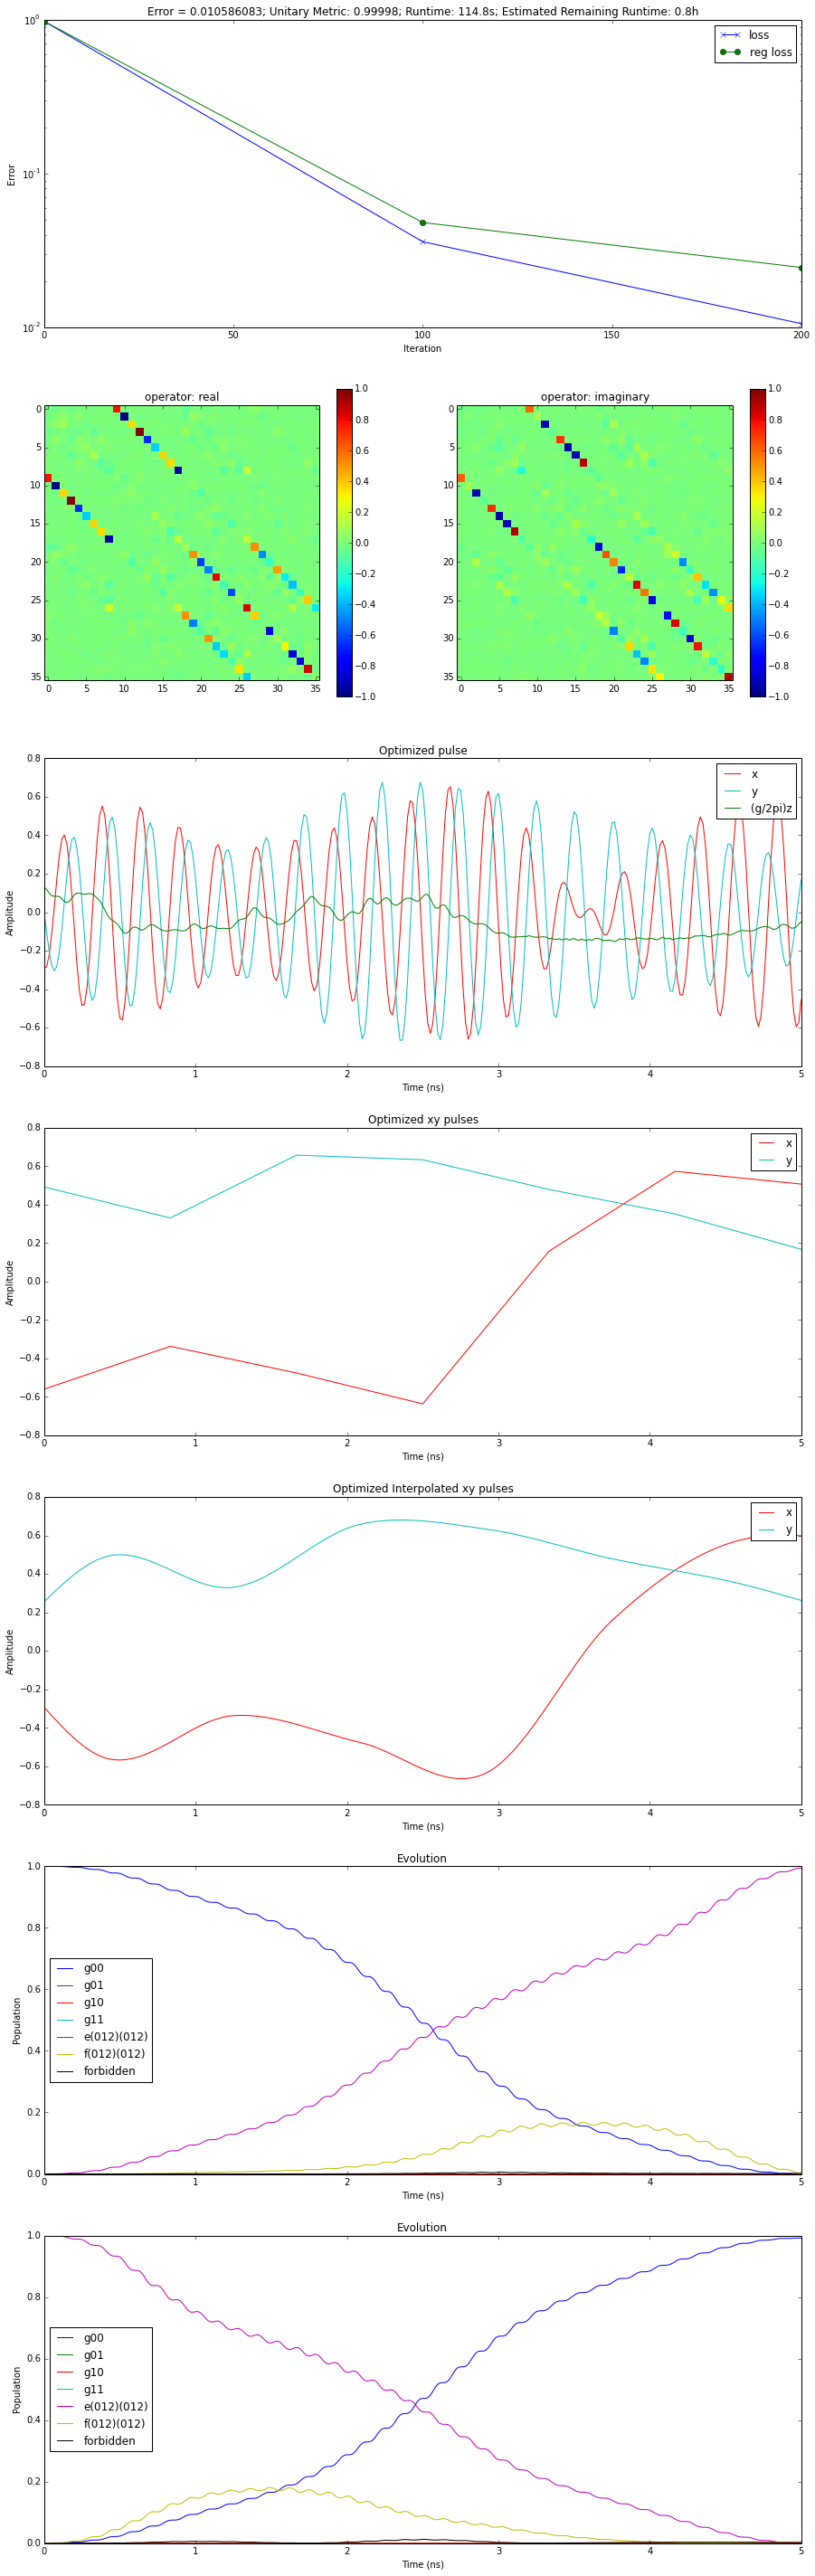

In [ ]:
try:
    run_session()
except KeyboardInterrupt:
    display.clear_output()